<a href="https://colab.research.google.com/github/Samiha9864/CVPR/blob/main/Digit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive for model saving
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import all required libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import io
import PIL.Image
from base64 import b64decode
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("🚀 Starting MNIST Digit Recognition Training...")


🚀 Starting MNIST Digit Recognition Training...


In [4]:
# 1. LOAD AND PREPROCESS DATA
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize and reshape for CNN
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, -1)  # Add channel dimension
x_test = np.expand_dims(x_test, -1)

print(f"✅ Data loaded: {x_train.shape[0]} train, {x_test.shape[0]} test samples")

# 2. CREATE DATA AUGMENTATION
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.1),          # ±10 degrees rotation
    layers.RandomTranslation(0.1, 0.1),  # ±10% translation
    layers.RandomZoom(0.1),            # ±10% zoom
])


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Data loaded: 60000 train, 10000 test samples


In [5]:
# 3. BUILD OPTIMIZED CNN MODEL
def create_model():
    inputs = keras.Input(shape=(28, 28, 1))

    # Apply augmentation only during training
    x = data_augmentation(inputs)

    # Convolutional blocks with batch normalization
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    # Dense layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    return keras.Model(inputs, outputs)

model = create_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,370 (435.04 KB)

 Trainable params: 110,922 (433.29 KB)

 Non-trainable params: 448 (1.75 KB)

In [6]:
# 4. COMPILE MODEL WITH OPTIMIZER AND CALLBACKS
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Setup training callbacks for better performance
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/best_mnist_model.h5',
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
   )
]


In [8]:
# 5. TRAIN THE MODEL
print("🏋 Training model...")
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

🏋 Training model...
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.5591 - loss: 1.2824
Epoch 1: val_accuracy improved from -inf to 0.15000, saving model to /content/drive/MyDrive/best_mnist_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 135s 280ms/step - accuracy: 0.5595 - loss: 1.2813 - val_accuracy: 0.1500 - val_loss: 6.2708 - learning_rate: 0.0010
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9134 - loss: 0.2928
Epoch 2: val_accuracy improved from 0.15000 to 0.97010, saving model to /content/drive/MyDrive/best_mnist_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 151s 300ms/step - accuracy: 0.9134 - loss: 0.2928 - val_accuracy: 0.9701 - val_loss: 0.0906 - learning_rate: 0.0010
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9364 - loss: 0.2155
Epoch 3: val_accuracy improved from 0.97010 to 0.98150, saving model to /content/drive/MyDrive/best_mnist_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 131s 277ms/step - accuracy: 0.9364 - loss: 0.2155 - val_accuracy: 0.9815 - val_loss: 0.0558 - learning_rate: 0.0010
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9489 - loss: 0.1759
Epoch 4: val_accuracy did not improve from 0.98150
469/469 ━━━━━━━━━━━━━━━━━━━━ 139s 272ms/step - accuracy: 0.9489 - loss: 0.1759 - val_accuracy: 0.9807 - val_loss: 0.0593 - learning_rate: 0.0010
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9530 - loss: 0.1571
Epoch 5: val_accuracy improved from 0.98150 to 0.98580, saving model to /content/drive/MyDrive/best_mnist_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 273ms/step - accuracy: 0.9530 - loss: 0.1571 - val_accuracy: 0.9858 - val_loss: 0.0436 - learning_rate: 0.0010
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9577 - loss: 0.1408
Epoch 6: val_accuracy did not improve from 0.98580
469/469 ━━━━━━━━━━━━━━━━━━━━ 129s 275ms/step - accuracy: 0.9577 - loss: 0.1408 - val_accuracy: 0.9843 - val_loss: 0.0493 - learning_rate: 0.0010
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9606 - loss: 0.1321
Epoch 7: val_accuracy improved from 0.98580 to 0.98790, saving model to /content/drive/MyDrive/best_mnist_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 275ms/step - accuracy: 0.9605 - loss: 0.1321 - val_accuracy: 0.9879 - val_loss: 0.0374 - learning_rate: 0.0010
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9625 - loss: 0.1252
Epoch 8: val_accuracy did not improve from 0.98790
469/469 ━━━━━━━━━━━━━━━━━━━━ 145s 283ms/step - accuracy: 0.9625 - loss: 0.1252 - val_accuracy: 0.9844 - val_loss: 0.0488 - learning_rate: 0.0010
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9638 - loss: 0.1196
Epoch 9: val_accuracy improved from 0.98790 to 0.98890, saving model to /content/drive/MyDrive/best_mnist_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 137s 272ms/step - accuracy: 0.9638 - loss: 0.1196 - val_accuracy: 0.9889 - val_loss: 0.0320 - learning_rate: 0.0010
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9634 - loss: 0.1237
Epoch 10: val_accuracy improved from 0.98890 to 0.99000, saving model to /content/drive/MyDrive/best_mnist_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 273ms/step - accuracy: 0.9634 - loss: 0.1237 - val_accuracy: 0.9900 - val_loss: 0.0292 - learning_rate: 0.0010
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9678 - loss: 0.1134
Epoch 11: val_accuracy improved from 0.99000 to 0.99060, saving model to /content/drive/MyDrive/best_mnist_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 128s 274ms/step - accuracy: 0.9678 - loss: 0.1134 - val_accuracy: 0.9906 - val_loss: 0.0304 - learning_rate: 0.0010
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9673 - loss: 0.1118
Epoch 12: val_accuracy did not improve from 0.99060
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 274ms/step - accuracy: 0.9673 - loss: 0.1118 - val_accuracy: 0.9896 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 13/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9687 - loss: 0.1081
Epoch 13: val_accuracy did not improve from 0.99060
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 274ms/step - accuracy: 0.9687 - loss: 0.1081 - val_accuracy: 0.9904 - val_loss: 0.0283 - learning_rate: 0.0010
Epoch 14/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9695 - loss: 0.1033
Epoch 14: val_accuracy did not improve from 0.99060
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 270ms/step - accuracy: 0.9695 - loss: 0.1033 - val_accuracy: 0.9890 - val_loss: 0.0335 - learning_rate: 0.00

469/469 ━━━━━━━━━━━━━━━━━━━━ 129s 275ms/step - accuracy: 0.9710 - loss: 0.0991 - val_accuracy: 0.9912 - val_loss: 0.0247 - learning_rate: 0.0010
Epoch 17/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.9697 - loss: 0.0955
Epoch 17: val_accuracy did not improve from 0.99120
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 272ms/step - accuracy: 0.9697 - loss: 0.0955 - val_accuracy: 0.9879 - val_loss: 0.0356 - learning_rate: 0.0010
Epoch 18/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9703 - loss: 0.0984
Epoch 18: val_accuracy did not improve from 0.99120
469/469 ━━━━━━━━━━━━━━━━━━━━ 129s 274ms/step - accuracy: 0.9703 - loss: 0.0984 - val_accuracy: 0.9908 - val_loss: 0.0278 - learning_rate: 0.0010
Epoch 19/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9718 - loss: 0.0951
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 19: val_accuracy did not improve from 0.99120
469/469 ━━━━━━━━━━━━━━━━━━━━ 144s 279ms/step - accuracy: 0.9718 

469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 279ms/step - accuracy: 0.9736 - loss: 0.0895 - val_accuracy: 0.9917 - val_loss: 0.0257 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 20.


In [9]:
# 6. EVALUATE MODEL PERFORMANCE
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"🎯 Final Test Accuracy: {test_accuracy*100:.2f}%")
print(f"📊 Final Test Loss: {test_loss:.4f}")

# Save final model
model.save('/content/drive/MyDrive/mnist_webcam_model.h5')
print("💾 Model saved successfully!")


🎯 Final Test Accuracy: 99.17%
📊 Final Test Loss: 0.0257
💾 Model saved successfully!


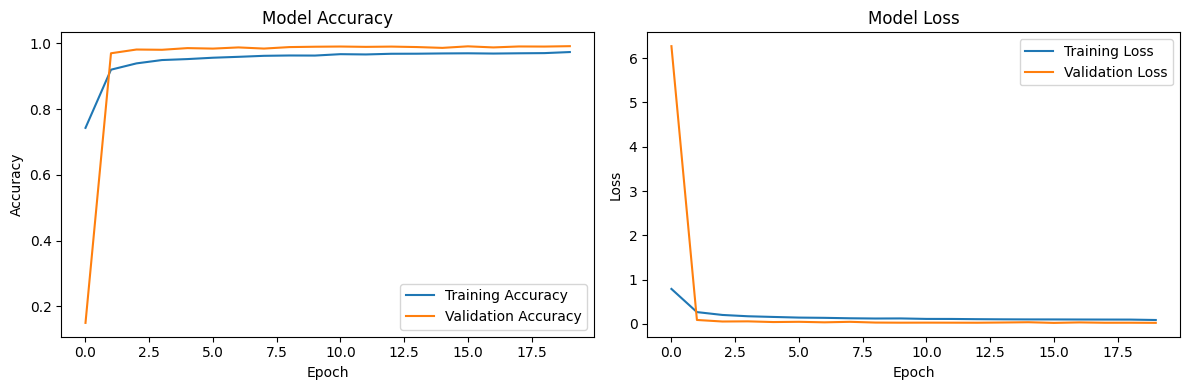

In [10]:
# 7. PLOT TRAINING HISTORY
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
# 8. ROBUST IMAGE PREPROCESSING FOR WEBCAM
def preprocess_webcam_image(roi):
    """Convert webcam ROI to MNIST-style 28x28 image"""
    # Convert to grayscale
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply adaptive threshold (white digit on black background)
    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 2
    )

    # Find contours to locate the digit
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Get the largest contour (assumed to be the digit)
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Extract digit region
        digit_roi = thresh[y:y+h, x:x+w]

        # Create square canvas
        size = max(w, h)
        square = np.zeros((size, size), dtype=np.uint8)

        # Center the digit in the square
        start_x = (size - w) // 2
        start_y = (size - h) // 2
        square[start_y:start_y+h, start_x:start_x+w] = digit_roi

        # Resize to 20x20 and pad to 28x28 (like MNIST)
        resized = cv2.resize(square, (20, 20), interpolation=cv2.INTER_AREA)
        final_image = np.zeros((28, 28), dtype=np.uint8)
        final_image[4:24, 4:24] = resized
    else:
        # Fallback: just resize the whole thresholded image
        final_image = cv2.resize(thresh, (28, 28), interpolation=cv2.INTER_AREA)

    # Normalize to [0,1] and reshape for model
    normalized = final_image.astype('float32') / 255.0
    return normalized.reshape(1, 28, 28, 1), final_image


In [12]:
# 9. WEBCAM JAVASCRIPT INTERFACE
def create_webcam_interface():
    """Create webcam interface with live overlay box"""
    js_code = Javascript('''
    async function setupWebcam() {
        // Create video element
        const video = document.createElement('video');
        video.style.width = '640px';
        video.style.height = '480px';
        video.setAttribute('playsinline', '');
        video.setAttribute('autoplay', '');

        // Create canvas for overlay
        const canvas = document.createElement('canvas');
        canvas.width = 640;
        canvas.height = 480;
        canvas.style.position = 'absolute';
        canvas.style.top = video.offsetTop + 'px';
        canvas.style.left = video.offsetLeft + 'px';

        // Create container with relative positioning
        const container = document.createElement('div');
        container.style.position = 'relative';
        container.style.display = 'inline-block';
        container.appendChild(video);
        container.appendChild(canvas);
        document.body.appendChild(container);

        // Get webcam stream
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        video.srcObject = stream;

        await new Promise((resolve) => {
            video.onloadedmetadata = () => resolve();
        });

        video.play();

        // Draw blue box overlay
        const ctx = canvas.getContext('2d');
        function drawOverlay() {
            ctx.clearRect(0, 0, canvas.width, canvas.height);

            // Calculate box position (center of video)
            const boxSize = 200;
            const x = (canvas.width - boxSize) / 2;
            const y = (canvas.height - boxSize) / 2;

            // Draw blue rectangle
            ctx.strokeStyle = '#0066FF';
            ctx.lineWidth = 4;
            ctx.strokeRect(x, y, boxSize, boxSize);

            // Add instruction text
            ctx.fillStyle = '#0066FF';
            ctx.font = '20px Arial';
            ctx.fillText('Draw digit here', x, y - 10);

            requestAnimationFrame(drawOverlay);
        }
        drawOverlay();

        // Create buttons
        const captureBtn = document.createElement('button');
        captureBtn.textContent = '📸 Capture & Predict';
        captureBtn.style.margin = '10px';
        captureBtn.style.padding = '10px';
        captureBtn.style.fontSize = '16px';
        captureBtn.style.display = 'block';
        document.body.appendChild(captureBtn);

        const stopBtn = document.createElement('button');
        stopBtn.textContent = '🛑 Stop';
        stopBtn.style.margin = '10px';
        stopBtn.style.padding = '10px';
        stopBtn.style.fontSize = '16px';
        captureBtn.style.display = 'block';
        document.body.appendChild(stopBtn);

        return new Promise((resolve) => {
            captureBtn.onclick = () => {
                const captureCanvas = document.createElement('canvas');
                captureCanvas.width = video.videoWidth;
                captureCanvas.height = video.videoHeight;
                captureCanvas.getContext('2d').drawImage(video, 0, 0);
                resolve(captureCanvas.toDataURL('image/jpeg', 0.8));
            };

            stopBtn.onclick = () => {
                stream.getTracks().forEach(track => track.stop());
                container.remove();
                captureBtn.remove();
                stopBtn.remove();
                resolve(null);
            };
        });
    }
    ''')
    display(js_code)

def dataurl_to_image(data_url):
    """Convert JavaScript dataURL to OpenCV image"""
    # Decode base64 data
    header, data = data_url.split(',', 1)
    binary_data = b64decode(data)

    # Convert to PIL image then to numpy array
    pil_image = PIL.Image.open(io.BytesIO(binary_data))
    numpy_image = np.array(pil_image)

    # Convert RGB to BGR for OpenCV
    opencv_image = numpy_image[:, :, ::-1].copy()
    return opencv_image


In [13]:
# 10. MAIN WEBCAM PREDICTION LOOP
def run_webcam_prediction():
    """Main function to run webcam digit recognition"""
    print("📷 Starting webcam digit recognition...")
    print("👉 Position your digit in the blue box and click 'Capture & Predict'")
    print("💡 The blue box shows exactly where the model will look for digits")

    # Load the trained model
    model = keras.models.load_model('/content/drive/MyDrive/best_mnist_model.h5')

    create_webcam_interface()

    while True:
        # Get frame from webcam
        data_url = eval_js('setupWebcam()')

        if data_url is None:
            print("🛑 Webcam stopped")
            break

        # Convert to OpenCV format
        frame = dataurl_to_image(data_url)
        h, w, _ = frame.shape

        # Calculate ROI coordinates (same as overlay)
        # Scale from display size (640x480) to actual video size
        display_w, display_h = 640, 480
        scale_x = w / display_w
        scale_y = h / display_h

        box_size_display = 200
        box_size_actual = int(box_size_display * min(scale_x, scale_y))

        x1 = w // 2 - box_size_actual // 2
        y1 = h // 2 - box_size_actual // 2
        x2 = x1 + box_size_actual
        y2 = y1 + box_size_actual

        # Extract ROI
        roi = frame[y1:y2, x1:x2]

        # Preprocess ROI for prediction
        model_input, processed_image = preprocess_webcam_image(roi)

        # Make prediction
        prediction = model.predict(model_input, verbose=0)
        predicted_digit = np.argmax(prediction)
        confidence = np.max(prediction) * 100

        # Create result display
        result_frame = frame.copy()

        # Draw the actual ROI box used for prediction
        cv2.rectangle(result_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Add prediction text with background
        text = f"Predicted: {predicted_digit} ({confidence:.1f}%)"
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1.2, 2)[0]
        cv2.rectangle(result_frame, (10, 10), (text_size[0] + 20, text_size[1] + 30), (0, 0, 0), -1)
        cv2.putText(result_frame, text, (15, 40),
                   cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

        # Display results
        print(f"🎯 Predicted: {predicted_digit} (Confidence: {confidence:.1f}%)")
        print(f"📏 ROI size: {box_size_actual}x{box_size_actual} pixels")
        cv2_imshow(result_frame)

        # Show processed image that goes to model
        print("Model input (28x28):")
        cv2_imshow(processed_image)

        time.sleep(0.5)



🎉 Training Complete! Ready for webcam prediction
📷 Starting webcam digit recognition...
👉 Position your digit in the blue box and click 'Capture & Predict'
💡 The blue box shows exactly where the model will look for digits


<IPython.core.display.Javascript object>

🎯 Predicted: 4 (Confidence: 63.6%)
📏 ROI size: 200x200 pixels


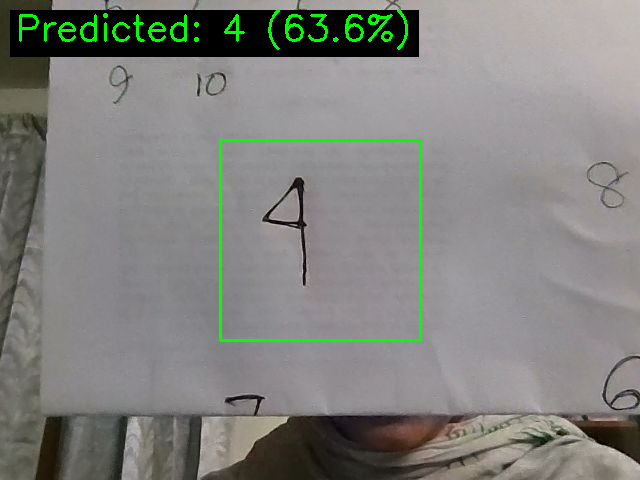

Model input (28x28):


🎯 Predicted: 1 (Confidence: 97.8%)
📏 ROI size: 200x200 pixels


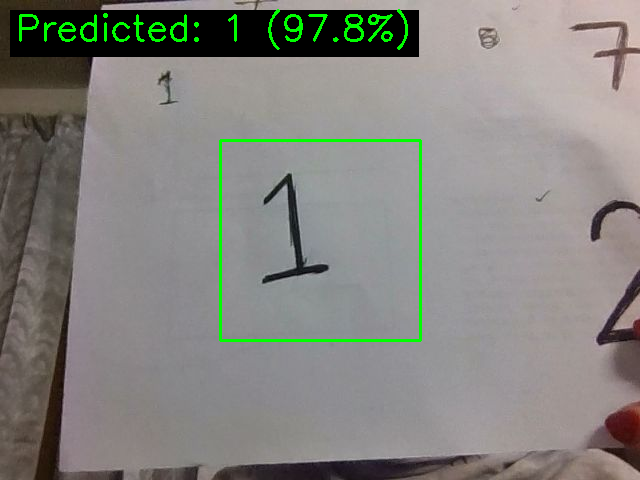

Model input (28x28):


🎯 Predicted: 8 (Confidence: 99.9%)
📏 ROI size: 200x200 pixels


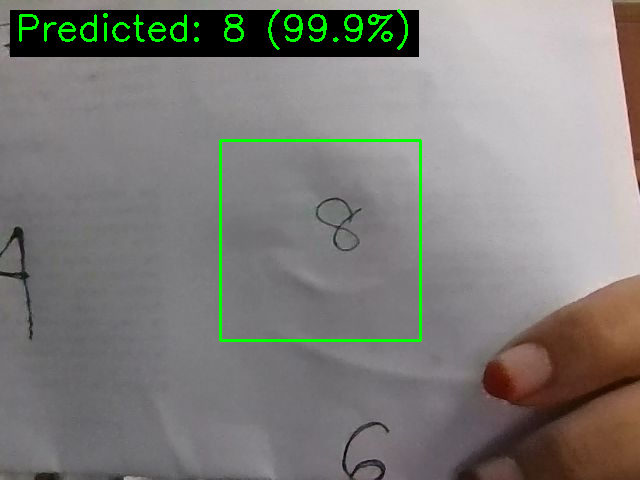

Model input (28x28):


🎯 Predicted: 7 (Confidence: 98.8%)
📏 ROI size: 200x200 pixels


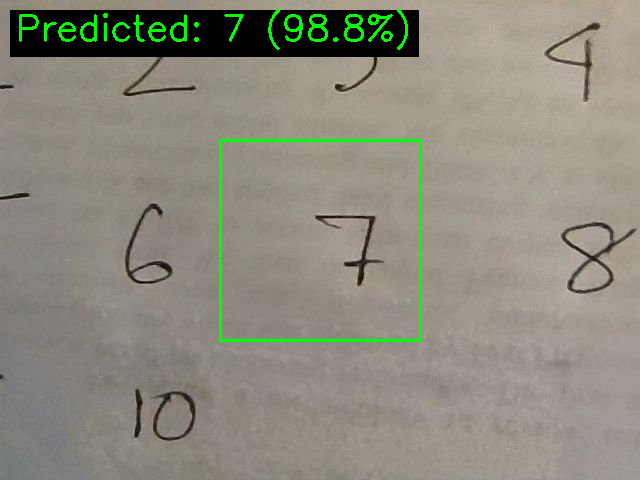

Model input (28x28):


🎯 Predicted: 3 (Confidence: 100.0%)
📏 ROI size: 200x200 pixels


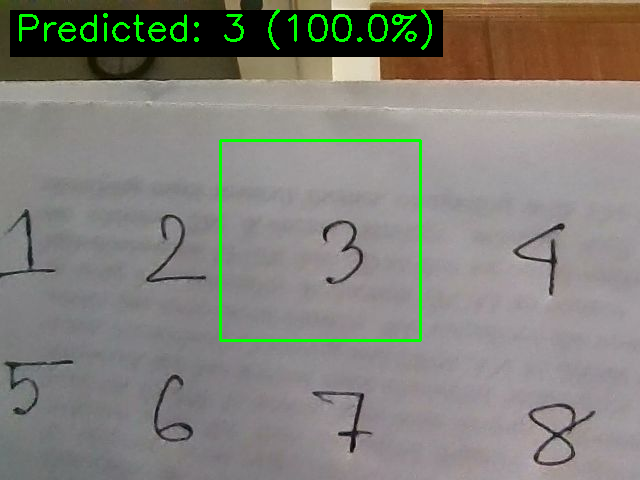

Model input (28x28):


🎯 Predicted: 5 (Confidence: 99.2%)
📏 ROI size: 200x200 pixels


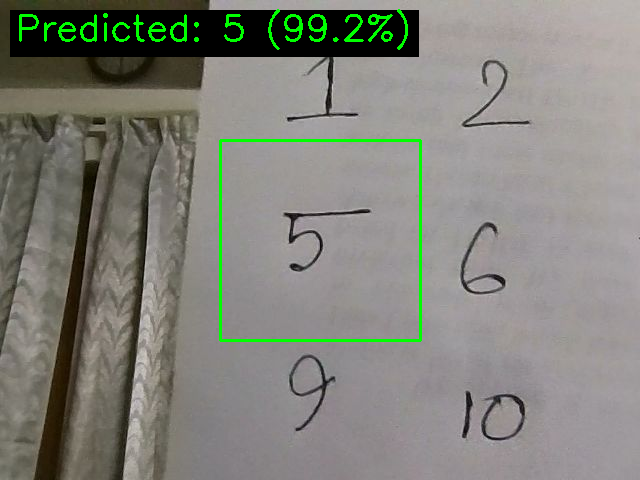

Model input (28x28):


🛑 Webcam stopped


In [15]:
# 11. RUN THE WEBCAM PREDICTION
print("\n" + "="*50)
print("🎉 Training Complete! Ready for webcam prediction")
print("="*50)

run_webcam_prediction()